In [1]:
import scipy as sp
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

In [2]:
path = r'D:\MScData\HistHyd_Iceland_Greenland_Seas_2015_2020.mat'

obs = sp.io.loadmat(path)
display(obs)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Nov  5 09:21:25 2024',
 '__version__': '1.0',
 '__globals__': [],
 'mat': array([[(array([[  4],
                [  5],
                [ 10],
                [ 15],
                [ 20],
                [ 25],
                [ 30],
                [ 35],
                [ 40],
                [ 45],
                [ 50],
                [ 55],
                [ 60],
                [ 65],
                [ 70],
                [ 75],
                [ 80],
                [ 85],
                [ 90],
                [ 95],
                [100],
                [120],
                [140],
                [160],
                [180],
                [200],
                [225],
                [250],
                [275],
                [292]], dtype=uint16), array([[2.673],
                [2.671],
                [2.709],
                [2.919],
                [3.701],
                [4.114],
      

In [47]:
# Extract the data
data = obs['mat']

# Initialize lists to store the data
press_list = []
temp_list = []
sal_list = []
lon_list = []
lat_list = []
time_list = []
source_list = []
id_list = []

# Loop through the data and extract each field
for entry in data[0]:
    press_list.append(entry[0].flatten().tolist())
    temp_list.append(entry[1].flatten().tolist())
    sal_list.append(entry[2].flatten().tolist())
    lon_list.append(entry[3].item())
    lat_list.append(entry[4].item())
    time_list.append(entry[5].item())
    source_list.append(entry[6].item())
    id_list.append(entry[7].item())

# Convert MATLAB datenum to datetime
def matlab_datenum_to_datetime(datenum):
    return datetime.fromordinal(int(datenum)) + timedelta(days=datenum % 1) - timedelta(days=366)

time_list = [matlab_datenum_to_datetime(t) for t in time_list]

# Create a pandas DataFrame
df = pd.DataFrame({
    'pressure': press_list,
    'temperature': temp_list,
    'salinity': sal_list,
    'longitude': lon_list,
    'latitude': lat_list,
    'time': time_list,
    'source': source_list,
    'ID': id_list
})

# Find the maximum length of the lists in 'pressure'
max_length = max(len(lst) for lst in df['pressure'])

# Pad the shorter lists with NaN values
pressure_padded = np.array([lst + [np.nan] * (max_length - len(lst)) for lst in df['pressure']])
temperature_padded = np.array([lst + [np.nan] * (max_length - len(lst)) for lst in df['temperature']])
salinity_padded = np.array([lst + [np.nan] * (max_length - len(lst)) for lst in df['salinity']])

# Create the xarray Dataset
ds = xr.Dataset(
    {
        'pressure': (['index', 'pressure_dim'], pressure_padded),
        'temperature': (['index', 'pressure_dim'], temperature_padded),
        'salinity': (['index', 'pressure_dim'], salinity_padded)
    },
    coords={
        'index': df.index,
        'longitude': ('index', df['longitude']),
        'latitude': ('index', df['latitude']),
        'time': ('index', df['time']),
        'pressure_dim': np.arange(max_length)
    }
)


# Display the xarray Dataset
display(ds)



<xarray.Dataset>
Dimensions:       (index: 6026, pressure_dim: 3790)
Coordinates:
  * index         (index) int64 0 1 2 3 4 5 6 ... 6020 6021 6022 6023 6024 6025
    longitude     (index) float64 -34.34 -33.99 -33.94 ... 4.998 4.999 5.0
    latitude      (index) float64 65.54 65.9 65.17 65.16 ... 74.5 74.5 76.33
    time          (index) datetime64[ns] 2015-10-17T08:25:00.000004 ... 2019-...
  * pressure_dim  (pressure_dim) int32 0 1 2 3 4 5 ... 3785 3786 3787 3788 3789
Data variables:
    pressure      (index, pressure_dim) float64 4.0 5.0 10.0 ... nan nan nan
    temperature   (index, pressure_dim) float64 2.673 2.671 2.709 ... nan nan
    salinity      (index, pressure_dim) float64 33.84 33.84 33.86 ... nan nan

In [49]:
# Extract the data
data = obs['mat']

# Initialize lists to store the data
press_list = []
temp_list = []
sal_list = []
lon_list = []
lat_list = []
time_list = []
source_list = []
id_list = []

# Loop through the data and extract each field
for entry in data[0]:
    press_list.append(entry[0].flatten().tolist())
    temp_list.append(entry[1].flatten().tolist())
    sal_list.append(entry[2].flatten().tolist())
    lon_list.append(entry[3].item())
    lat_list.append(entry[4].item())
    time_list.append(entry[5].item())
    source_list.append(entry[6].item())
    id_list.append(entry[7].item())

# Convert MATLAB datenum to datetime
def matlab_datenum_to_datetime(datenum):
    return datetime.fromordinal(int(datenum)) + timedelta(days=datenum % 1) - timedelta(days=366)

time_list = [matlab_datenum_to_datetime(t) for t in time_list]

# Create a pandas DataFrame
df = pd.DataFrame({
    'pressure': press_list,
    'temperature': temp_list,
    'salinity': sal_list,
    'longitude': lon_list,
    'latitude': lat_list,
    'time': time_list,
    'source': source_list,
    'ID': id_list
})

# Find the maximum length of the lists in 'pressure'
max_length = max(len(lst) for lst in df['pressure'])

# Pad the shorter lists with NaN values
pressure_padded = np.array([lst + [np.nan] * (max_length - len(lst)) for lst in df['pressure']])
temperature_padded = np.array([lst + [np.nan] * (max_length - len(lst)) for lst in df['temperature']])
salinity_padded = np.array([lst + [np.nan] * (max_length - len(lst)) for lst in df['salinity']])

# Create the xarray Dataset
ds = xr.Dataset(
    {
        'pressure': (['index', 'pressure_dim'], pressure_padded),
        'temperature': (['index', 'pressure_dim'], temperature_padded),
        'salinity': (['index', 'pressure_dim'], salinity_padded)
    },
    coords={
        'index': df.index,
        'longitude': ('index', df['longitude']),
        'latitude': ('index', df['latitude']),
        'time': ('index', df['time']),
        'pressure_dim': np.arange(max_length)
    }
)

# Create a multi-index for latitude and longitude
ds = ds.set_index(index=['latitude', 'longitude'])

# Display the xarray Dataset
display(ds)

<xarray.Dataset>
Dimensions:       (index: 6026, pressure_dim: 3790)
Coordinates:
    time          (index) datetime64[ns] 2015-10-17T08:25:00.000004 ... 2019-...
  * pressure_dim  (pressure_dim) int32 0 1 2 3 4 5 ... 3785 3786 3787 3788 3789
  * index         (index) object MultiIndex
  * latitude      (index) float64 65.54 65.9 65.17 65.16 ... 74.5 74.5 76.33
  * longitude     (index) float64 -34.34 -33.99 -33.94 ... 4.998 4.999 5.0
Data variables:
    pressure      (index, pressure_dim) float64 4.0 5.0 10.0 ... nan nan nan
    temperature   (index, pressure_dim) float64 2.673 2.671 2.709 ... nan nan
    salinity      (index, pressure_dim) float64 33.84 33.84 33.86 ... nan nan

# Test extracting all data at 10 dbar

In [50]:
dbar10 = ds['pressure'].where(ds['pressure']==10)
salinity_dbar10 = ds['salinity']*dbar10*(1/10)
salinity_dbar10 = salinity_dbar10.max(dim='pressure_dim')

C:\Users\eirik\AppData\Local\Temp\ipykernel_42924\2454756631.py:29: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(mesh)


Text(0, 0.5, 'Latitude')

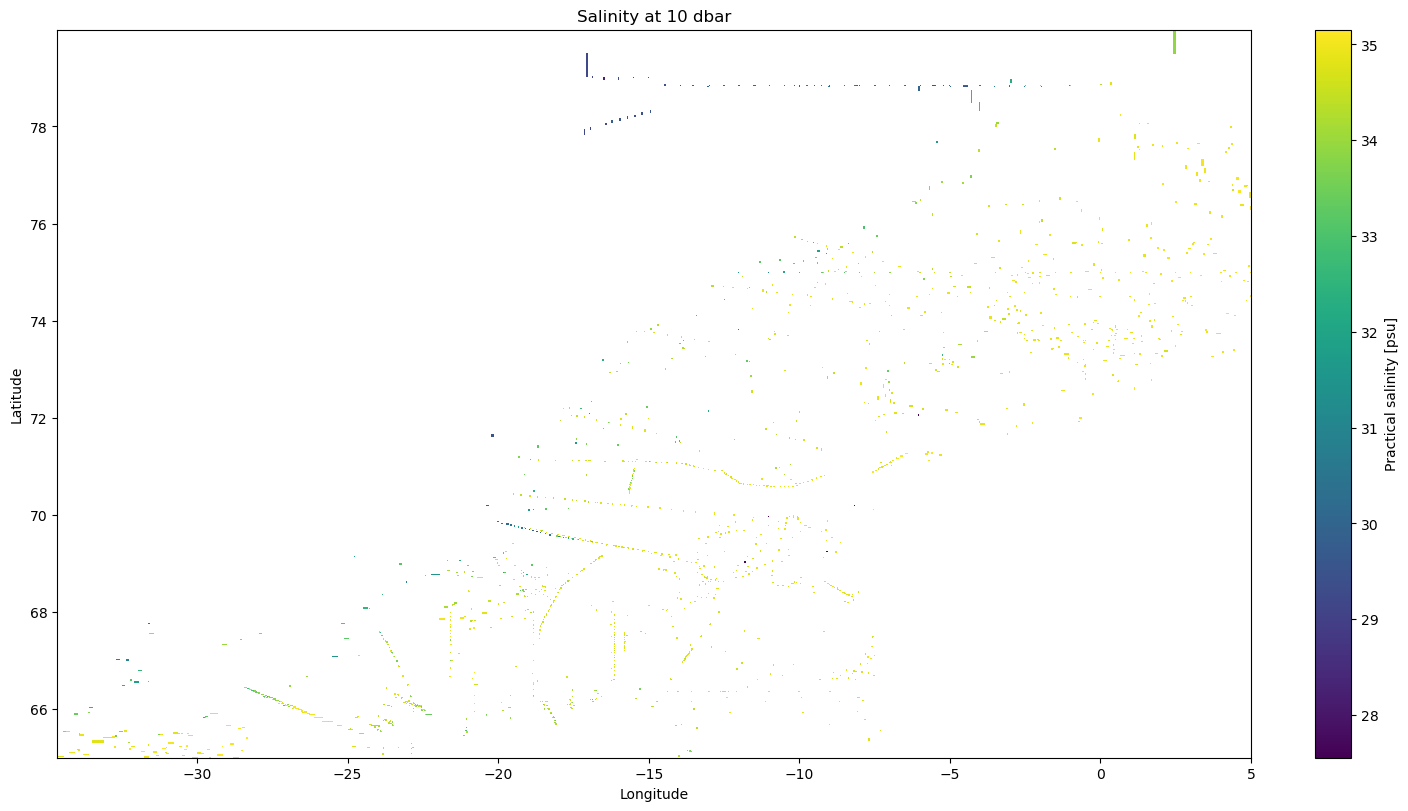

In [63]:
# Extract salinity values at 10 dbar
salinity_at_10_dbar = []
longitude_at_10_dbar = []
latitude_at_10_dbar = []

for i, pressures in enumerate(df['pressure']):
    if 10 in pressures:
        idx = pressures.index(10)
        salinity_at_10_dbar.append(df['salinity'][i][idx])
        longitude_at_10_dbar.append(df['longitude'][i])
        latitude_at_10_dbar.append(df['latitude'][i])

# Create a DataFrame for the extracted values
df_10_dbar = pd.DataFrame({
    'salinity': salinity_at_10_dbar,
    'longitude': longitude_at_10_dbar,
    'latitude': latitude_at_10_dbar
})

# Aggregate the data by averaging the salinity values for each unique pair of latitude and longitude
df_10_dbar_agg = df_10_dbar.groupby(['latitude', 'longitude']).mean().reset_index()

# Pivot the DataFrame to create a 2D array for plotting
salinity_pivot = df_10_dbar_agg.pivot(index='latitude', columns='longitude', values='salinity')

# Plot the data
fig, ax = plt.subplots(figsize=(14, 8), layout='constrained')
mesh = ax.pcolor(salinity_pivot.columns, salinity_pivot.index, salinity_pivot.values, cmap='viridis')
cbar = fig.colorbar(mesh)
cbar.set_label('Practical salinity [psu]')
ax.set_title('Salinity at 10 dbar')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')